In [76]:
import numpy as np
from scipy.optimize import minimize
import copy
import cv2
import math
import scipy.interpolate as scipy_interpolate
from time import sleep
import os
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

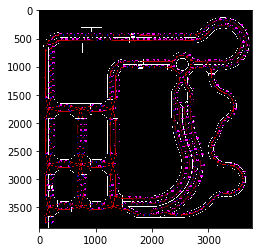

In [13]:
G = nx.read_graphml('comp_track.graphml')
import cv2
img=cv2.imread("Competition_track.png")
plt.imshow(img)

1
{'x': 2.1, 'y': 10.47}
2
{'x': 2.1, 'y': 10.83}
3
{'x': 2.68, 'y': 11.41}
4
{'x': 3.05, 'y': 11.41}
5
{'x': 3.63, 'y': 10.83}
6
{'x': 3.63, 'y': 10.47}
7
{'x': 3.05, 'y': 9.89}
8
{'x': 2.68, 'y': 9.89}
9
{'x': 2.86, 'y': 10.65}
10
{'x': 2.86, 'y': 10.65}
11
{'x': 2.86, 'y': 10.65}
12
{'x': 2.86, 'y': 10.65}
18
{'x': 3.61, 'y': 6.61}
17
{'x': 3.61, 'y': 6.98}
16
{'x': 3.04, 'y': 7.54}
15
{'x': 2.68, 'y': 7.54}
13
{'x': 2.11, 'y': 6.61}
14
{'x': 2.11, 'y': 6.98}
19
{'x': 2.86, 'y': 6.79}
20
{'x': 2.86, 'y': 6.79}
21
{'x': 2.86, 'y': 6.79}
27
{'x': 5.27, 'y': 7.55}
26
{'x': 4.9, 'y': 7.55}
25
{'x': 4.34, 'y': 6.99}
24
{'x': 4.34, 'y': 6.62}
22
{'x': 5.27, 'y': 6.06}
23
{'x': 4.9, 'y': 6.06}
28
{'x': 5.09, 'y': 6.81}
29
{'x': 5.09, 'y': 6.81}
30
{'x': 5.09, 'y': 6.81}
36
{'x': 5.27, 'y': 11.39}
35
{'x': 4.91, 'y': 11.39}
34
{'x': 4.35, 'y': 10.82}
33
{'x': 4.35, 'y': 10.46}
31
{'x': 5.27, 'y': 9.9}
32
{'x': 4.91, 'y': 9.9}
37
{'x': 5.09, 'y': 10.64}
38
{'x': 5.09, 'y': 10.64}
39
{'x': 5.

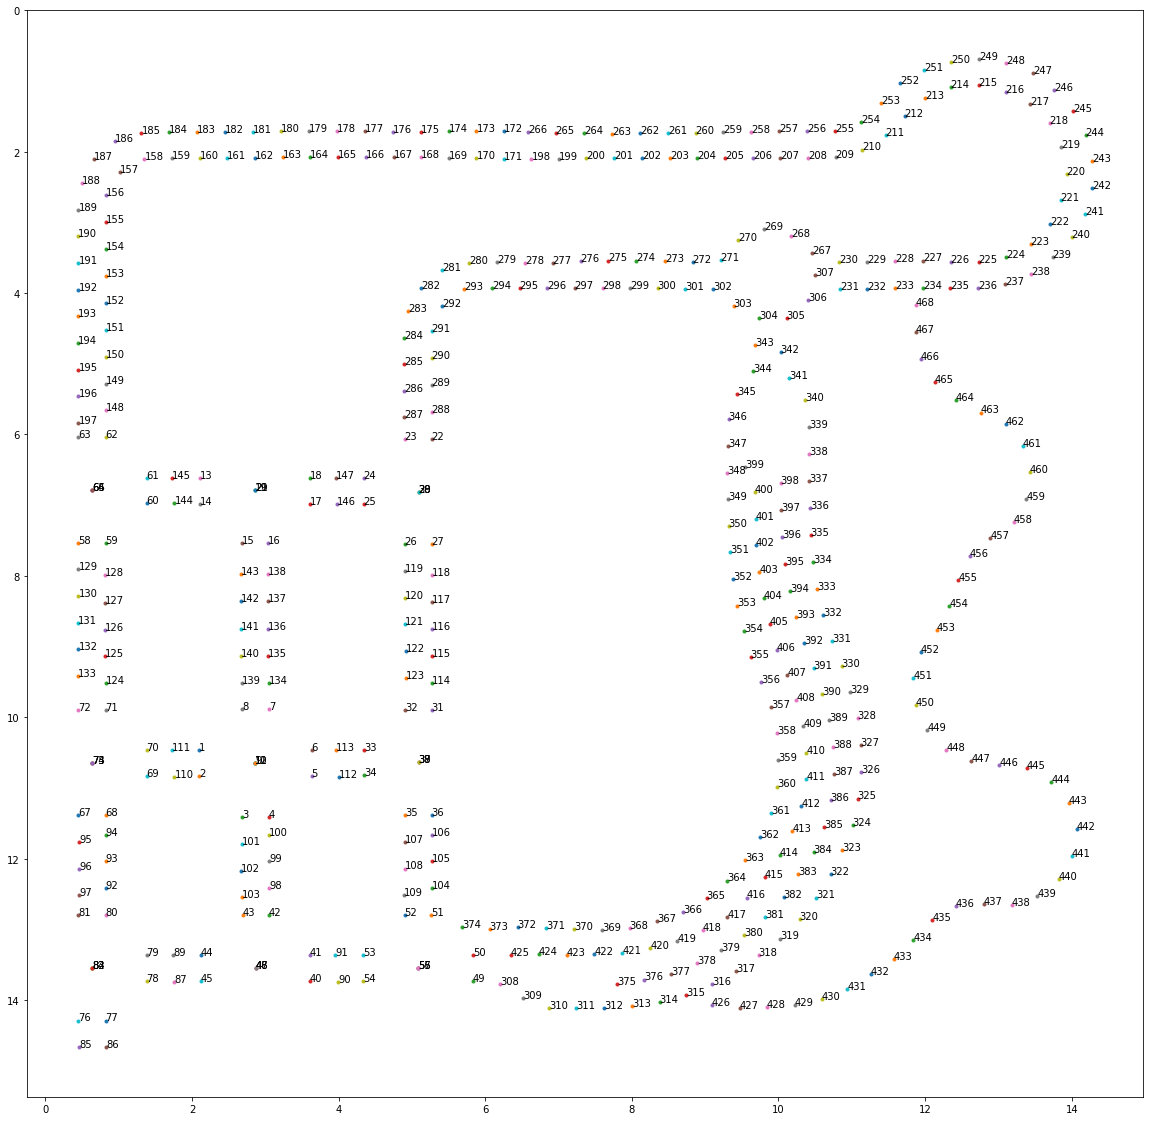

In [23]:
plt.figure(figsize=(20,20))
for node,data in G.nodes(data=True):
    print(node)
    print(data)
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()
# plt.legend()
# plt.show()

In [3]:
class Car_Dynamics:
    def __init__(self, x_0, y_0, v_0, psi_0, length, dt):
        self.dt = dt             # sampling time
        self.L = length          # vehicle length
        self.x = x_0
        self.y = y_0
        self.v = v_0
        self.psi = psi_0
        self.state = np.array([[self.x, self.y, self.v, self.psi]]).T

    def move(self, accelerate, delta):
        x_dot = self.v*np.cos(self.psi)
        y_dot = self.v*np.sin(self.psi)
        v_dot = accelerate
        psi_dot = self.v*np.tan(delta)/self.L
        return np.array([[x_dot, y_dot, v_dot, psi_dot]]).T

    def update_state(self, state_dot):
        # self.u_k = command
        # self.z_k = state
        self.state = self.state + self.dt*state_dot
        self.x = self.state[0,0]
        self.y = self.state[1,0]
        self.v = self.state[2,0]
        self.psi = self.state[3,0]

    
class MPC_Controller:
    def __init__(self):
        self.horiz = None
        self.R = np.diag([0.01, 0.01])                 # input cost matrix
        self.Rd = np.diag([0.01, 1.0])                 # input difference cost matrix
        self.Q = np.diag([1.0, 1.0])                   # state cost matrix
        self.Qf = self.Q                               # state final matrix

    def mpc_cost(self, u_k, my_car, points):
        mpc_car = copy.copy(my_car)
        u_k = u_k.reshape(self.horiz, 2).T
        z_k = np.zeros((2, self.horiz+1))
    
        desired_state = points.T
        cost = 0.0

        for i in range(self.horiz):
            state_dot = mpc_car.move(u_k[0,i], u_k[1,i])
            mpc_car.update_state(state_dot)
        
            z_k[:,i] = [mpc_car.x, mpc_car.y]
            cost += np.sum(self.R@(u_k[:,i]**2))
            cost += np.sum(self.Q@((desired_state[:,i]-z_k[:,i])**2))
            if i < (self.horiz-1):     
                cost += np.sum(self.Rd@((u_k[:,i+1] - u_k[:,i])**2))
        return cost

    def optimize(self, my_car, points):
        self.horiz = points.shape[0]
        bnd = [(-5, 5),(np.deg2rad(-60), np.deg2rad(60))]*self.horiz
        result = minimize(self.mpc_cost, args=(my_car, points), x0 = np.zeros((2*self.horiz)), method='SLSQP', bounds = bnd)
        return result.x[0],  result.x[1]

In [70]:
my_car = Car_Dynamics(start[0], start[1], -math.pi/2, np.deg2rad(0), length=4, dt=0.1)

In [71]:
MPC_HORIZON = 5
controller = MPC_Controller()

In [94]:
sx = 3.6  # start x position [m]
sy = 1.72  # start y positon [m]
gx = 2.45  # goal x position [m]
gy = 1.72  # goal y position [m]
grid_size = 0.05  # potential grid size [m]
robot_radius = 0.05  # robot radius [m]

In [100]:
ox = [3.21, 2.8]  # obstacle x position list [m]
oy = [1.5, 1.69]  # obstacle y position list [m]

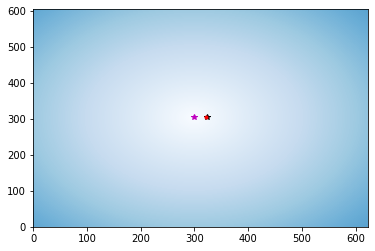

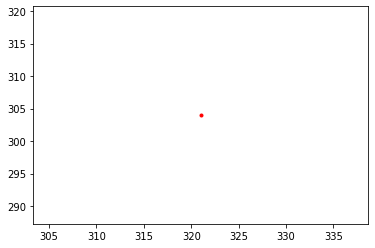

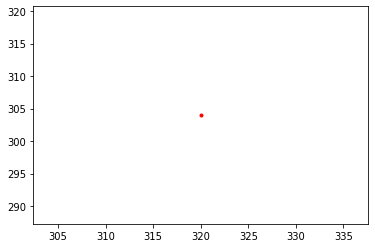

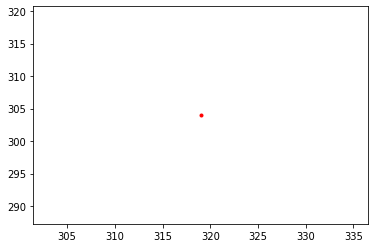

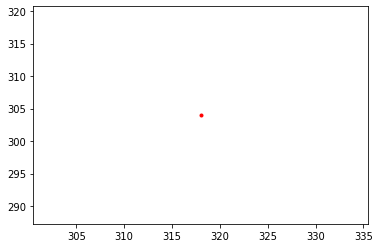

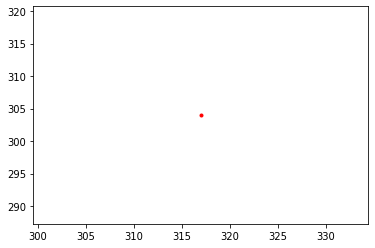

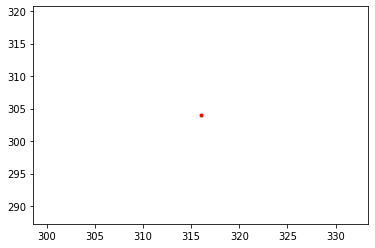

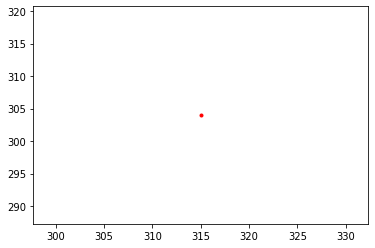

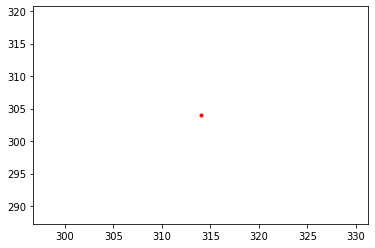

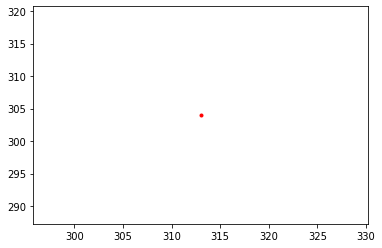

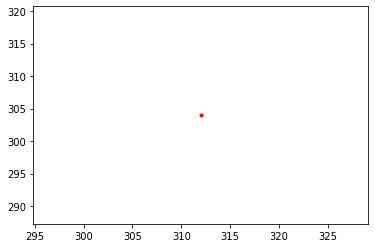

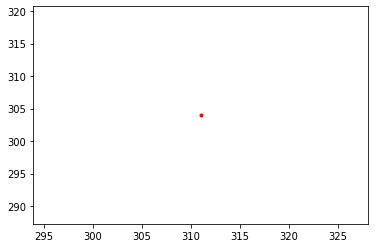

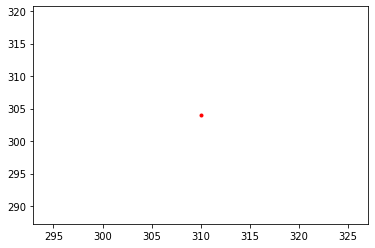

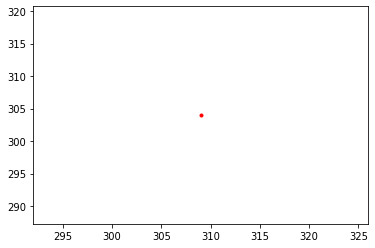

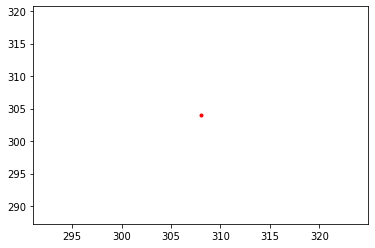

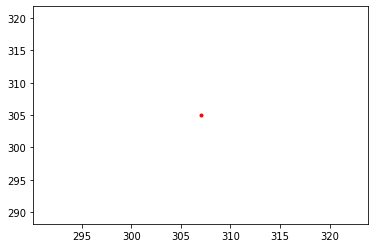

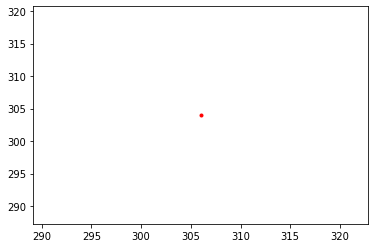

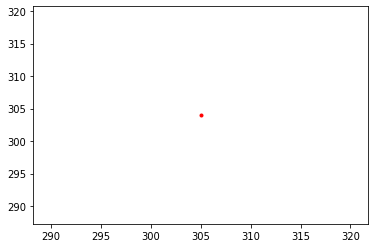

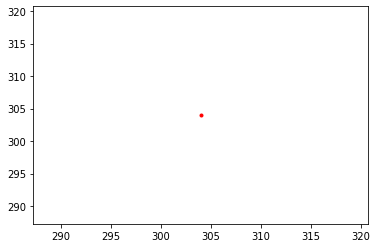

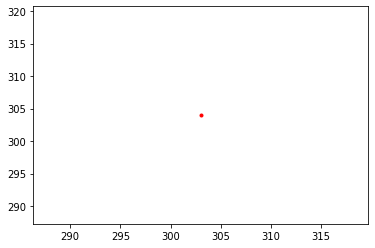

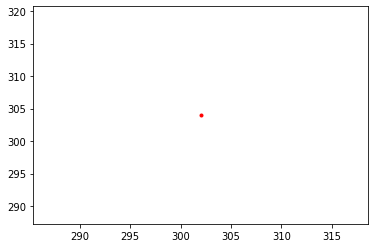

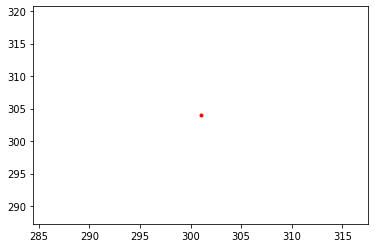

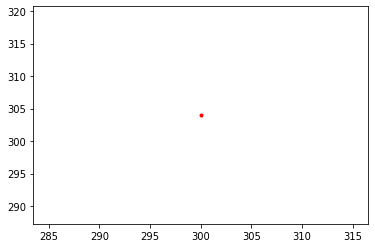

Goal!!


In [101]:
rx, ry = potential_field_planning(
        sx, sy, gx, gy, ox, oy, grid_size, robot_radius)

In [102]:
print(rx)

[3.6, 3.5500000000000007, 3.5, 3.4499999999999993, 3.4000000000000004, 3.3499999999999996, 3.3000000000000007, 3.25, 3.1999999999999993, 3.1500000000000004, 3.0999999999999996, 3.0500000000000007, 3.0, 2.9499999999999993, 2.9000000000000004, 2.8499999999999996, 2.8000000000000007, 2.75, 2.6999999999999993, 2.6500000000000004, 2.5999999999999996, 2.5500000000000007, 2.5, 2.4499999999999993]


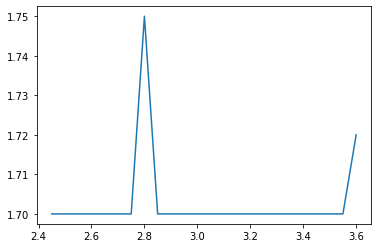

In [103]:
plt.plot(rx, ry)